# Individual Assignment - Computational Media Analysis

- Corpus preparation [6 points]
- Lexical extraction [6 pts]
- Temporal analysis [6 pts]
- Topic modelling [6 pts]


### Library pre-loading
You will most likely need to load a series of libraries to complete the assignment
If a library is missing. Remember it is easy to install it using the following syntax: 

```python
!pip install library_name
```

or alternatively depending on your system
```python
!pip3 install library_name
```


In [1]:
#please make sure this executes properly before moving forward. 

import spacy
import pandas as pd

import json
import spacy
import requests
import random
import time

import spacy
import tqdm
from collections import Counter

import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

import pyLDAvis
import pyLDAvis.gensim

# Corpus preparation 
📰 Let's download data from the New York Times API.

Donwload a corpus from the NYT API. 
- You need to specify a search query, and optionnaly a meaningful time range (please remember that the data will be collected from the most recent articles to the oldest)
- Make sure to download a corpus composed of at least 1.000 articles.
- Please write a short text explaining why you think this corpus (search query) is interesting to investigate.
- And make sure to save the data as a csv file. Please, first use use the consolidate_corpus function which turns the outcome of the search_nyt_articles function into a dataframe. This dataframe can then later be saved as a csv file using the syntax: 
```python
df.to_csv('my_corpus.csv',index=False)
```
- At a later stage you can open your corpus using the following syntax (no need to download data from the API again)
```python
df=pd.read_csv('my_corpus.csv')
```
- Display 5 random rows in the dataframe. 

### Search query

The intersection of "Biden" and the "Inflation Reduction Act" (IRA) within the context of the New York Times (NYT) API presents a compelling avenue for research due to its multifaceted implications. Firstly, the IRA, as a significant policy initiative under President Biden, represents a pivotal aspect of his administration's economic agenda. Analyzing the discourse surrounding this substantial project provides insights into the complexities of policy implementation and its potential societal impacts.

Moreover, the research design is particularly intriguing in light of the upcoming 2024 elections. Investigating how discussions around the IRA may influence political narratives and public opinion offers valuable perspectives on the dynamic interplay between policy decisions and electoral dynamics. The stark divide between Republicans and Democrats adds an additional layer of complexity, shedding light on the polarization inherent in contemporary political discourse on climate change, renewable energy and the financial instruments within the IRA that aim to increase green investment.

The choice of the NYT as the primary source of analysis is crucial, given its extensive global readership and influence. Understanding how one of the leading media outlets frames the connection between Biden and the IRA contributes to a broader comprehension of information dissemination and its impact on shaping public perception. In essence, this research design not only delves into the intricacies of a significant policy but also unravels the intricate tapestry of political, social, and media dynamics in the United States.

The chosen timeframe for this research is pivotal in capturing the comprehensive evolution of discussions surrounding the Inflation Reduction Act (IRA). Enacted into law in August 2022, the IRA's roots extend back to the last days of 2021 when it emerged as a reformed version of the previously neglected Build Back Better Act (December 2021). By examining the discourse leading up to the implementation and extending beyond, this research encapsulates the nuanced deliberations that shape perceptions of the IRA.

Opting for the full name as a keyword, the "Inflation Reduction Act", rather than the abbreviated "IRA", aligns with the journalistic approach of introducing the complete title before employing the acronym throughout the rest of the article. Additionally, due to Joe Biden's Irish heritage, when using the acronym "IRA" as a keyword for the search could, the possibility cannot be ruled out (without further research) that "IRA" would refer to the Irish Republican Army (IRA) and the linked current debated in Irish politics.

In [2]:
# First copy and paste your API key
my_api_key="61YzqF98XTMZuuqYjsNMmuuWZUN4raWS"

In [8]:
import requests
def number_of_articles(api_key,keyword,begin_date="20211201",end_date="20240331"):
    url_query = f"https://api.nytimes.com/svc/search/v2/articlesearch.json?fq={keyword}&begin_date={begin_date}&end_date={end_date}&api-key={api_key}"
    print (url_query)
    res = requests.get(url_query)
    json_res = res.json()
    hits = json_res["response"]["meta"]["hits"]
    return hits

#number of articles available in this time frame with both key words: we learn, that 22.468 articles are available
print(number_of_articles(api_key=my_api_key,keyword="Inflation Reduction Act"))
    

https://api.nytimes.com/svc/search/v2/articlesearch.json?fq=Inflation Reduction Act&begin_date=20211201&end_date=20240331&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
22468


In [9]:
#function to interact with the NYT API
def search_nyt_articles(api_key,keyword,max_pages,begin_date="20211201",end_date="20240331"):

    docs = []
    
    #I added this to be able to check whether and when the code fails throughout the hour-long running
    ntimes=0
    ntf=0

    for i in range(max_pages):
        
        api = f"https://api.nytimes.com/svc/search/v2/articlesearch.json?q={keyword}&begin_date={begin_date}&end_date={end_date}&page={i+1}&api-key={api_key}"
        print (api)
        response = requests.get(api)
        data = response.json()
        try:
            ntimes=ntimes+1
            docs.extend(data['response']['docs'])
        except:
            ntf=ntf+1
            #return docs
        time.sleep(12)
    
    print('n times it works', ntimes)
    print('n times it fails', ntf)
    return docs

articles = search_nyt_articles(api_key=my_api_key,
                                 keyword="Inflation Reduction Act",
                                 begin_date="20211201",
                                 max_pages=200)

https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=1&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=2&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=3&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=4&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=5&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=6&api-key=61YzqF98XTMZuuqYjsN

https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=50&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=51&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=52&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=53&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=54&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=55&api-key=61YzqF98XTMZu

https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=99&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=100&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=101&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=102&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=103&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=104&api-key=61YzqF98

https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=147&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=148&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=149&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=150&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=151&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=152&api-key=61YzqF9

https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=195&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=196&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=197&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=198&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=199&api-key=61YzqF98XTMZuuqYjsNMmuuWZUN4raWS
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Inflation Reduction Act&begin_date=20211201&end_date=20240331&page=200&api-key=61YzqF9

In [10]:
#turn the generated set of articles into a dataframe containing the headline, leadparagraphs and date of each article 
def consolidate_corpus(articles):
    docs=[]
    for article in articles:
        #here it would be possible to modify (include abstract, captions, etc.) but then if an article does not have an abstract we potentially have to drop them later, thus decision not to modify
        docs.append([article['headline']['main'],article['lead_paragraph'],article['pub_date'],article['news_desk'],article['web_url']])
    corpus=pd.DataFrame(docs,columns=['Headline','Leadparagraph','Date','News Desk','Website url'])
    return corpus
corpus = consolidate_corpus(articles)


In [11]:
corpus.to_csv('my_corpus.csv',index=False)

In [12]:
#just to make sure: check my article keys
articles[0].keys()

dict_keys(['abstract', 'web_url', 'snippet', 'lead_paragraph', 'print_section', 'print_page', 'source', 'multimedia', 'headline', 'keywords', 'pub_date', 'document_type', 'news_desk', 'section_name', 'subsection_name', 'byline', 'type_of_material', '_id', 'word_count', 'uri'])

In [16]:
corpus.sample(5)

,Headline,Leadparagraph,Date,News Desk,Website url
81,"With National Monument Designation, Biden Trie...",After spending most of his appearance near the...,2023-08-08T23:37:56+0000,Washington,https://www.nytimes.com/2023/08/08/us/politics...
449,Surprise Deal Would Be Most Ambitious Climate ...,WASHINGTON — The $369 billion climate and tax ...,2022-07-28T09:00:19+0000,Climate,https://www.nytimes.com/2022/07/28/climate/cli...
694,"In Compromise, the Climate Left May Be Vindicated","The deal, if it holds, is very big, several ti...",2022-07-29T10:00:06+0000,OpEd,https://www.nytimes.com/2022/07/29/opinion/env...
663,How Liberals Should Confront a Right-Wing Supr...,"For American progressives, the Supreme Court h...",2022-10-17T09:00:21+0000,OpEd,https://www.nytimes.com/2022/10/17/opinion/lib...
268,"After Warmth From Biden, South Korea’s Leader ...",President Yoon Suk Yeol went to Washington to ...,2023-04-29T09:00:35+0000,Foreign,https://www.nytimes.com/2023/04/29/world/asia/...


In [13]:
#just to make sure: check article 100's abstract
articles[99]['abstract']

'It takes five years to connect a new wind or solar farm to the electric grid. New federal rules would only partly resolve the issue, experts say.'

In [14]:
#Task: check if there are at least 1.000 articles in the dataframe
len(corpus)
#or: corpus.apply(len)
#or: corpus (prints, cf. last row for len)

899

## Short comment: corpus length
While number_of_articles above displays that there are 3725 articles available for my search query (keywords and timeframe), after running the download with max_pages 200, my corpus length is limited to a little over 600 articles. This is unexpected in a towfold way: 1) a max_pages of 200 should give me a corpus that features 2000 articles (200x10) and 2) especially after number_of_articles showing that there are >2000 articles for the same search query.

I have talked through the search query and the code with Camille and we were not able to identify why the corpus is limited. I can forward you his email if needed. Since 3725 articles are available for "Biden" and "Inflation Reduction Act" and we have not been able to identify the limit's reason, I will work with the 600+ articles here.

In [14]:
#Task: Display five random rows in the dataframe
corpus.sample(5)

,Headline,Leadparagraph,Date
24,Republicans’ Problem in Attacking Biden: They ...,President Biden isn’t the only one doing a ful...,2023-06-29T09:00:41+0000
243,"Once You See the Truth About Cars, You Can’t U...","In American consumer lore, the automobile has ...",2022-12-15T10:00:21+0000
183,"Biden, in Midterm Campaign Pitch, Focuses on S...","MIAMI GARDENS, Fla. — President Biden pressed ...",2022-11-02T00:10:28+0000
94,Biden’s Highest Hurdle Isn’t Age. It’s Passion.,Joe Biden is officially running for re-electio...,2023-04-27T00:17:38+0000
413,"Democrats Buoyed by Abortion and Trump, Times/...",Even as they struggle to persuade voters that ...,2022-09-16T07:00:09+0000


# Lexical extraction
📊 
- Extract and display the 10 most frequently used adjectives in the leadparagraph of your corpus
- Extract and display the 10 most frequently used adjectives in the leadparagraph+headline of your corpus
- Extract and display the 10 most frequently mentioned names in the leadparagraph of your corpus using NER (you should check spacy documentation to find how to do so) 
- Comment on these last results

### short comment on task nr. 3
I had finished this task during the fall break and then, on Monday Nov 5th, changed the "nouns" into "names" after your announcement to change the logic of assignment 3 (lexical extraction) in class.

In [15]:
nlp = spacy.load("en_core_web_sm")

In [16]:
#activate to load the corpus when skipping the corpus preparation part
#corpus=pd.read_csv('my_corpus.csv')

In [17]:
#Task: extract and display the 10 most frequently used adjectives in the leadparagraphs
texts = []
for art in articles:
    texts.append(art['lead_paragraph'])

spacydocs = []
for text in tqdm.tqdm(texts):
    spacydocs.append(nlp(text))

adjectives = []
for doc in spacydocs:
    for token in doc:
        if token.pos_ == "ADJ":
            adjectives.append(token.text)

print(Counter(adjectives).most_common(10))

100%|██████████| 611/611 [00:12<00:00, 50.41it/s]

[('new', 52), ('electric', 50), ('last', 42), ('federal', 40), ('more', 37), ('first', 33), ('American', 32), ('economic', 29), ('Republican', 29), ('other', 27)]


In [18]:
#Task: extract and display the 10 most frequently used adjectives in the leadparagraphs and headlines
texts = []
for art in articles:
    lead_paragraph = art['lead_paragraph']
    headline = art['headline']['main']
    
    texts.extend([lead_paragraph, headline])
    
spacydocs = []
for text in tqdm.tqdm(texts):
    spacydocs.append(nlp(text))

adjectives = []
for doc in spacydocs:
    for token in doc:
        if token.pos_ == "ADJ":
            adjectives.append(token.text)

print(Counter(adjectives).most_common(10))

100%|██████████| 1222/1222 [00:18<00:00, 66.86it/s]

[('new', 53), ('electric', 50), ('last', 42), ('federal', 40), ('more', 38), ('American', 35), ('first', 33), ('Republican', 30), ('economic', 29), ('other', 27)]


In [19]:
#Task: extract and display the 10 most frequently used names in the leadparagraphs (using Named Entity Recognition)

names = []
for art in articles:
    lead_paragraph = art.get('lead_paragraph', '')
    #to control missing values
    doc = nlp(lead_paragraph)
    
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            #to ask to check if it is a Person/ a person's name
            names.append(ent.text)
            
most_common_names = Counter(names).most_common(10)
for name, count in most_common_names:
    print(f"{name}: {count}")

Biden: 222
Ezra Klein: 23
Joe Manchin III: 9
Donald Trump: 9
Joe Biden: 8
Kevin McCarthy: 8
Donald J. Trump: 8
Janet L. Yellen: 7
Chuck Schumer: 5
Joe Manchin: 5


## Comment 1:
While NER can show us the ten most frequently used names in the leadparagraphs - with "Biden" being unsurprisingly (as it is a keyword in the search query) by far the most common - it does not know the actual individuals behind these names and thus does not recognize that references to "Joe Manchin III" and "Joe Manchin"/ "Donald Trump" and "Donald J. Trump" refer to the same person in reality.

Similarly, one could argue this applies to "Biden" and "Joe Biden". However, the NYT would also refer to the "Biden" administration. Then, the article could focus on the current US government or, still, on the perception of Joe Biden as a political figue. We cannot know without the context. Interestingly enough, the NER does not identify "Trump" as one of the ten most commonly used names, hence it is possible that articles with 'Inflation Reduction Act' and 'Biden' do not directly compare the former Trump administration with the current Biden administration.

In [20]:
#One step further: eliminate the doubles (Joe Manchin III/ Joe Manchin; Donald Trump/ Donald J. Trump)
import re

def rearranged_name(name):
    #Remove the III and J.(Trump)
    name = re.sub(r'\b(?:III|J. |’s)\b', '', name)
    #here, I added "’s" because when I ran the code to converge "III" and "J.", the result included "Joe Biden's" and I also want to eliminate this possessive

    return name.strip()

names = []
for art in articles:
    lead_paragraph = art.get('lead_paragraph', '')
    doc = nlp(lead_paragraph)
    
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            names.append(rearranged_name(ent.text))
            
most_common_names = Counter(names).most_common(10)
for name, count in most_common_names:
    print(f"{name}: {count}")


Biden: 223
Ezra Klein: 23
Donald Trump: 18
Joe Manchin: 14
Joe Biden: 12
Kevin McCarthy: 8
Janet L. Yellen: 7
Chuck Schumer: 5
Barack Obama: 4
Kyrsten Sinema: 4


## Comment 2:
I have now 'cleaned up' the data with the exception for "Biden" vs. "Joe Biden" since I do not want to distort the results regarding the above mentioned "Biden administration" possibility. Similarly, I have not touched the "L." in "Janet L. Yellen" as her name does not appear twice. 

A clearer picture concerning the ten most commonly mentioned people emerges. While the original task at hand was to identify the ten most common names, I have  changed this to the ten most mentioned people, since, from a social sciences research approach, we want to learn about the individuals, not the different versions of their names, associated with the search query. It is thus possible to identify the ten most commonly mentioned people including e.g., Barack Obama and Kyrsten Sinema - names that did not appear in the first version. 

Unsurprisingly, again, "Biden" features most prominently as "Biden" has been part of our search query. The second ranked name, "Ezra Klein", has not changed either. Ezra Klein is a well-known political journalist and podcaster who has his own column in the NYT. Since all other names refer to politicians, it surprises to see the name of a journalist rank second. On the other hand, his 'the Ezra Klein show' is widely quoted including either his or his guests' statements. Additionally, transcripts of his interviews are published in the NYT. Hence, it might also be the case that his name appears from transcripts that mark him as the speaker (e.g., "Ezra Klein: [question for the guest]") What has become more evident through this adjusted code is that "Donald Trump" has been recognized - here, we need to be aware that the NER might not have identified all NE correctly - by the NER more often than "Joe Manchin". This could not be gathered immediately at first sight from the results of the first version. Joe Biden has gained 4 points (from 8 to 12) since it now includes the "Joe Biden's" into "Joe Biden" (cf. comment in the code above).

# Temporal evolution
📊 
- Plot the evolution of the numer of articles published every week
[Hint, you should start with the dataframe saved in the first section, and change its index:

```python
df.date=pd.to_datetime(df.date)
df.index=df.date
```
and then use the resample function]

- Plot the average number of words per week

- Write a function that plots the evolution of times a word is found in the dataset.

- Choose a few words, plot their frequency evolution and comment.

In [2]:
#activate to load the corpus when skipping the corpus preparation part
#corpus=pd.read_csv('my_corpus.csv')

In [4]:
corpus.Date=pd.to_datetime(corpus.Date)
corpus.index=corpus.Date

In [5]:
#Task: Plot the evolution of the number of articles published every week
articles_per_week = corpus.resample('W').count()

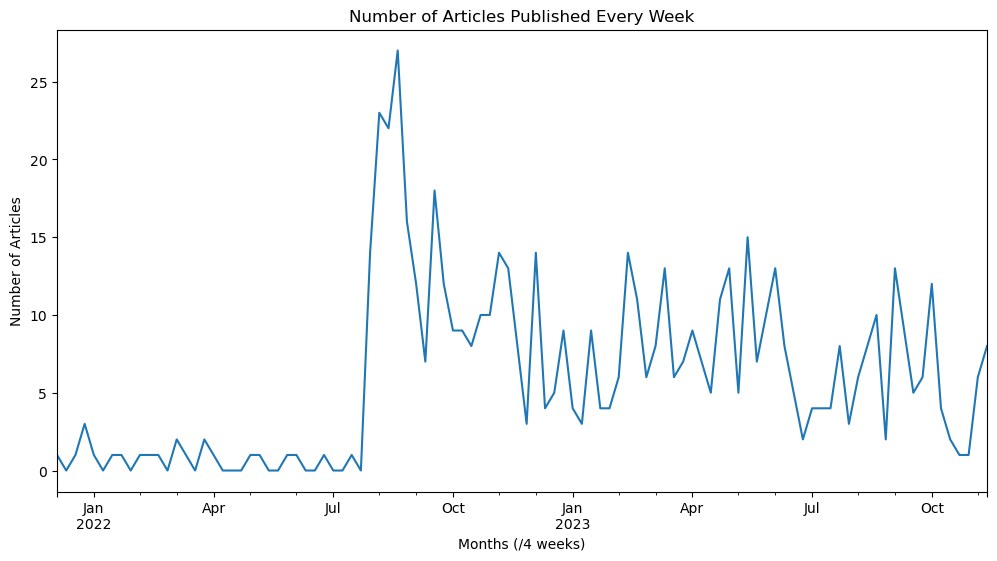

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
articles_per_week ['Headline'].plot(kind='line', ax=ax)
plt.title('Number of Articles Published Every Week')
plt.xlabel('Months (/4 weeks)')
plt.ylabel('Number of Articles')
plt.show()

In [25]:
#Task: Plot the average number of words per week
def count_words(lead_paragraph):
    return len(lead_paragraph.split(" "))

corpus['word_count'] = corpus['Leadparagraph'].apply(count_words)

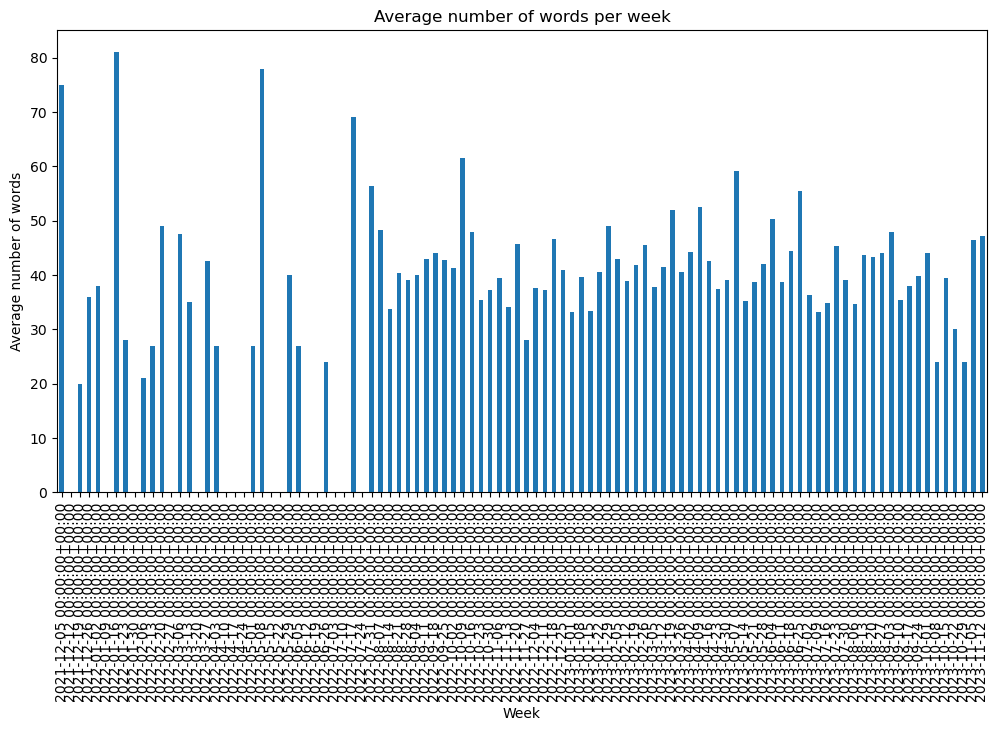

In [26]:
average_words_per_week = corpus.resample('W')['word_count'].mean()

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
average_words_per_week.plot(kind='bar', ax=ax)
plt.xlabel('Week')
plt.ylabel('Average number of words')
plt.title("Average number of words per week")
plt.show()

#### Short comment: gaps
here add comment on gaps and that those are weeks where no articles at least in this set

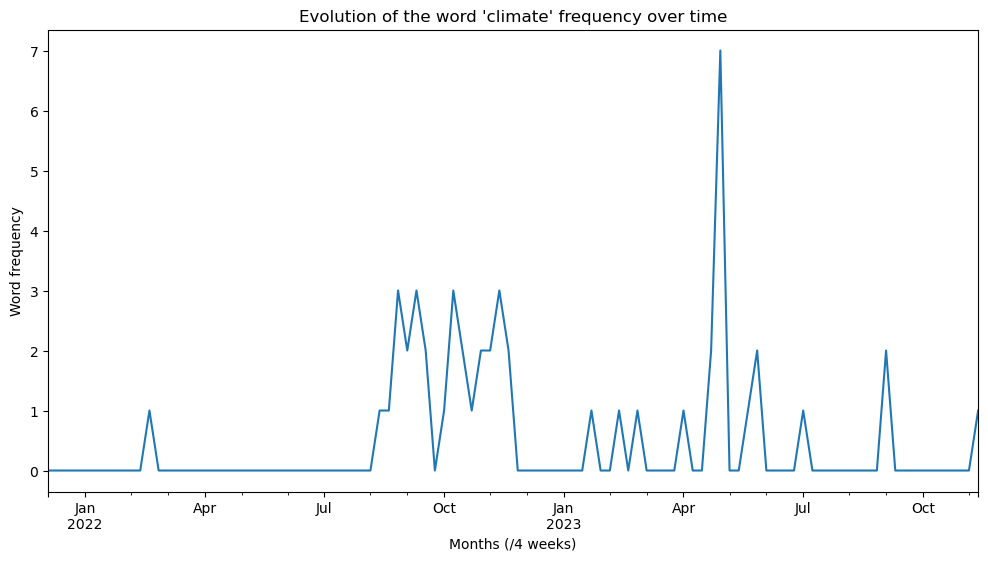

In [28]:
#Task: write a function that plots the evolution of times a word is found in the dataset
def word_frequency_plot(word):
    corpus["Leadparagraph"].fillna('', inplace=True)
    
    corpus["word_frequency"] = corpus['Leadparagraph'].str.lower().apply(lambda x: x.count(word.lower()))

    weekly_word_frequency = corpus.resample("W")['word_frequency'].sum()

    fig, ax = plt.subplots(figsize=(12, 6))
    weekly_word_frequency.plot(kind='line', ax=ax)
    plt.xlabel("Months (/4 weeks)")
    plt.ylabel("Word frequency")
    plt.title("Evolution of the word 'climate' frequency over time")
    plt.show()

word_frequency_plot('election')

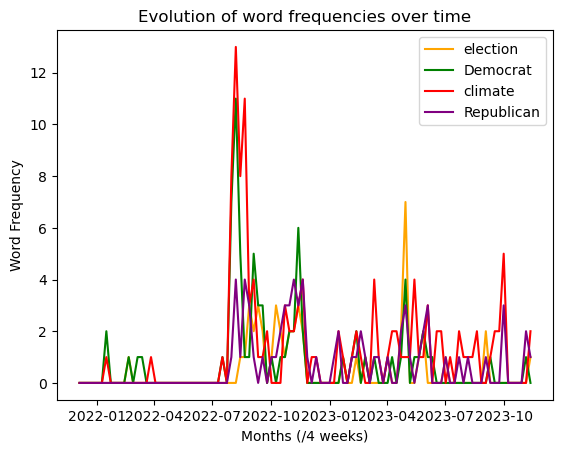

In [36]:
#Task: choose a few words, plot their frequency evolution and comment

def words_frequency_evolution_plot(corpus, words, colors):
    corpus["Leadparagraph"].fillna('', inplace=True)

    for word, color in zip(words, colors):
        corpus[f"word_frequency_{word}"] = corpus['Leadparagraph'].str.lower().apply(lambda x: x.count(word.lower()))
        weekly_word_frequency = corpus.resample("W")[f"word_frequency_{word}"].sum()
        plt.plot(weekly_word_frequency, label=word, color=color)

    plt.xlabel("Months (/4 weeks)")
    plt.ylabel("Word Frequency")
    plt.title("Evolution of word frequencies over time")
    plt.legend()
    plt.show()

four_words_list = ["election", "Democrat", "climate", "Republican"]
colors = ['orange', 'green', 'red', 'purple']

words_frequency_evolution_plot(corpus, four_words_list, colors)

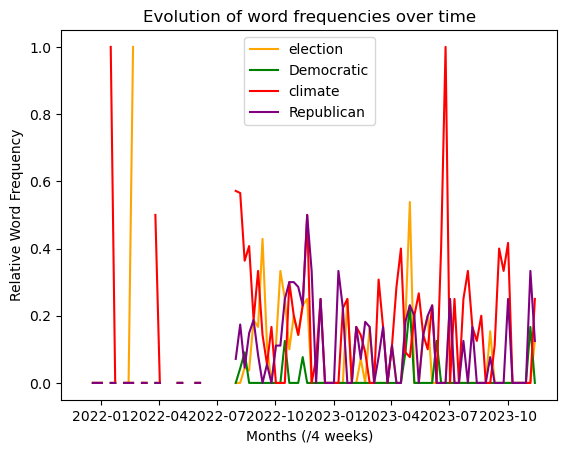

In [42]:
def relative_word_frequency_evolution_plot(corpus, words, colors):
    corpus["Leadparagraph"].fillna('', inplace=True)

    #calculate relative word frequencies for each word --> standardized view
    for word, color in zip(words, colors):
        corpus[f"word_frequency_{word}"] = corpus['Leadparagraph'].str.lower().apply(lambda x: x.count(word.lower()))
        weekly_word_frequency = corpus.resample("W")[f"word_frequency_{word}"].mean()
        #using mean for relative frequency
        plt.plot(weekly_word_frequency, label=word, color=color)

    plt.xlabel("Months (/4 weeks)")
    plt.ylabel("Relative Word Frequency")
    plt.title("Evolution of word frequencies over time")
    plt.legend()
    plt.show()

four_words_list = ["election", "Democratic", "climate", "Republican"]
colors = ['orange', 'green', 'red', 'purple']

relative_word_frequency_evolution_plot(corpus, four_words_list, colors)

### Short comment:
The second graph takes into account the relative distribution of the frequency of words over time (week). This gives a value between 0 and 1, representing the proportion of articles containing each word in each week relative to the total number of articles in that week. This can provide a more normalized view of the word frequency within the articles featured in the corpus.

Since plotting the four words in one graph makes the results less readable at first sight (even after adjusting colours to be more contrasting), I plotted the words seperate as well:

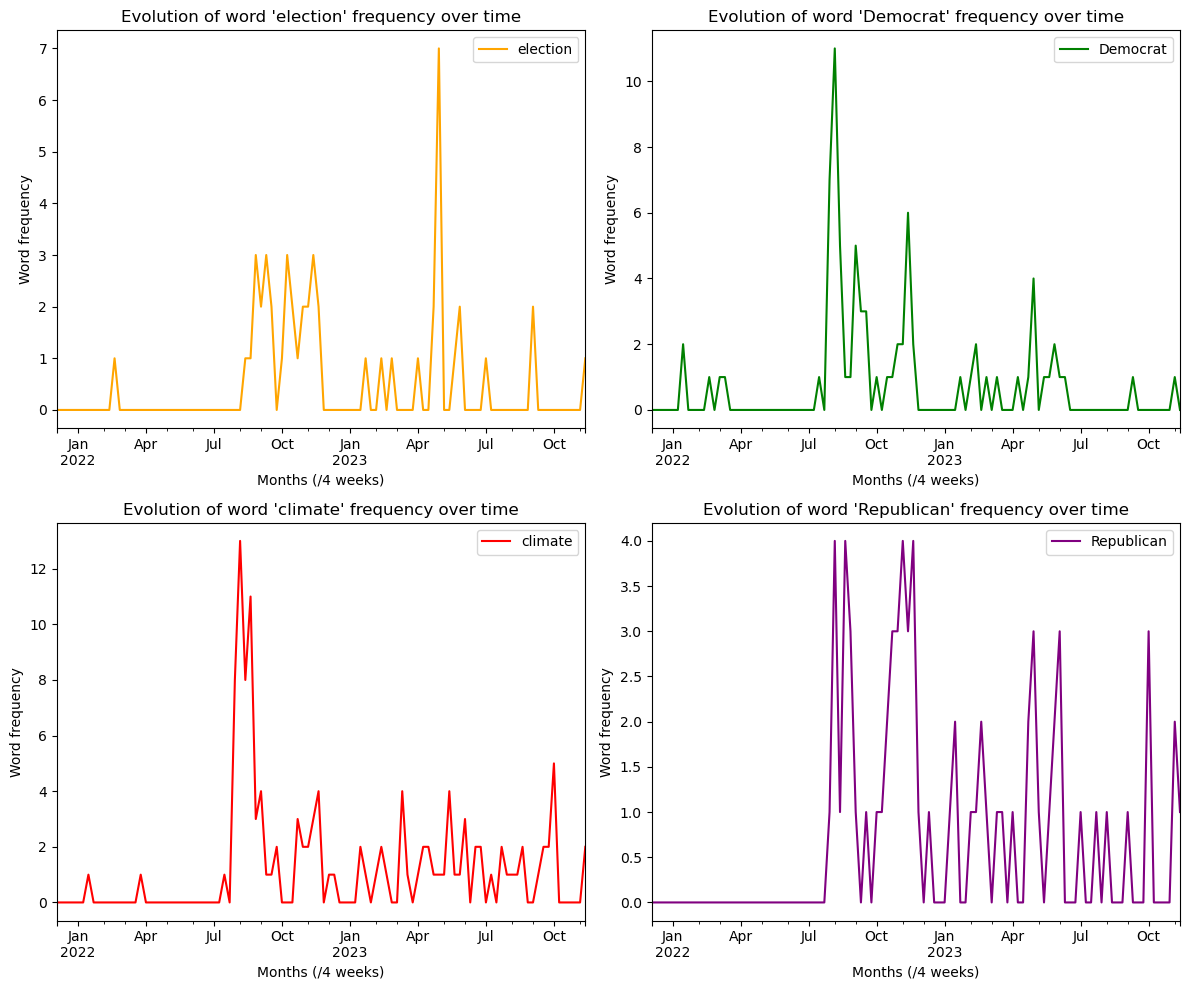

In [43]:
def word_frequency_evolution_plwords_plot(ax, corpus, word, color):
    corpus["Leadparagraph"].fillna('', inplace=True)
    corpus[f"word_frequency_{word}"] = corpus['Leadparagraph'].str.lower().apply(lambda x: x.count(word.lower()))
    weekly_word_frequency = corpus.resample("W")[f"word_frequency_{word}"].sum()
    weekly_word_frequency.plot(kind='line', ax=ax, label=word, color=color)
    ax.set_xlabel("Months (/4 weeks)")
    ax.set_ylabel("Word frequency")
    ax.set_title(f"Evolution of word '{word}' frequency over time")
    ax.legend()

four_words_list = ["election", "Democrat", "climate", "Republican"]
colors = ['orange', 'green', 'red', 'purple']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, (word, color) in enumerate(zip(four_words_list, colors)):
    row = i // 2
    col = i % 2
    word_frequency_evolution_plwords_plot(axes[row, col], corpus, word, color)

plt.tight_layout()
plt.show()

## Comment:
Interpreting word frequency involves considering the context of the dataset. In order to standardize the view of the word frequency within the articles featured in this corpus, I have adjusted a relative graph (cf. short comment above).

For an overall observation, all four selected words rise in frequency after July 2022. This is not surprising as, in the graph depicting the number of articles published every week, a parallel growing number in articles published becomes visible. Here, we have to reflect on how the code we used influenced the API article download. As more recently published articles were prioritized, the distribution of articles over time plotted above does not necessarily depict the whole picture. However, since the August-sheduled vote on the IRA was being prepared and discussed by both, Democrats and Republicans, increased media coverage through the NYT seems logical in the days leading up to the vote. Hence, a spike in published articles metioning the IRA and Biden could be connected to the vote's proximity. Altogether, out of the selected words, climate is mentioned most, followed by Democrat, election and then Republican.

As can be seen from the combination first plot (all word frequencies together)and the seperate plot for "climate", the word frequency for "climate" peaked at a significantly high level between mid-July and September 2022. However, speaking in terms of relative frequency, the word "climate" distributed over the overall articles featured in this corpus per week, peaked in the beginning of 2022 as well as, again, in July (this time, 2023). Perhaps, the topic of climate is, generally, more discussed with the high temperatures of late summer. However, at least in July 2022 the final vote on the IRA bill was about to be held and discussions on the IRA's climate change mitigation mechanisms ran higher.

While "climate" shows few significant peaks, the featuring of "Republican" shows to be more evenly distributed after July 2022. We can detect certain rises right before (July until mid-August) and after (October) the final Congress vote on Aug 16th. Democrat shows a similar pattern, although a higher overall frequency. This might be due to the fact that the IRA Bill is a project of President Biden and the Democratic Party.

Finally, "election" experienced relative frequency peaks in the beginning of 2022 and April/ May 2023. In absolute frequency, August to December 2022 as well as April 2023 mark significant high points. As mid-term elections (the general elections that are held near the midpoint of a president's four-year term of office) were held in November 2022, a peak in "election" for the prior months adds up. Connecting this to the IRA we see that even after the bill passed, it was still part of the discourse around Biden and the election context. 

# Topic Modeling

📊 Build a topic model using your corpus. You are free to choose the number of topics. 
- Display the topics compisition and give them a label
- Suggest a global interpretation of the topic structure
- Take one topic and show the 3 most pertinent documents pertinent for this topic
- Choose two topics and define a metrics that allows you to identify the 3 documents which best fit those two topics. 

In [44]:
#activate to load the corpus when skipping the corpus preparation part
#corpus=pd.read_csv('my_corpus.csv')

In [45]:
corpus['full_text']=corpus['Headline']+corpus['Leadparagraph']

In [46]:
corpus['length']=corpus['full_text'].apply(len)

In [47]:
corpus['length'].describe()

count     611.000000
mean      314.775777
std       128.156847
min        53.000000
25%       236.000000
50%       312.000000
75%       370.000000
max      1203.000000
Name: length, dtype: float64

In [48]:
#corpus_text=corpus['Lead Paragraph'].values
corpus_text=corpus.full_text.values

In [49]:
nlp = spacy.load("en_core_web_sm")
documents_nlp = []
for d in tqdm.tqdm(nlp.pipe(corpus_text,n_process=5),total=len(corpus_text)):
    documents_nlp.append(d)

100%|██████████| 611/611 [00:14<00:00, 43.00it/s] 


In [50]:
for token in documents_nlp[0]:
    print(token,token.pos_)

Want VERB
to PART
Spur VERB
Green PROPN
Energy PROPN
in ADP
Wyoming PROPN
? PUNCT
Aim VERB
for ADP
the DET
Billionaires NOUN
. PUNCT
If SCONJ
the DET
area NOUN
around ADP
Jackson PROPN
, PUNCT
Wyo PROPN
. PROPN
, PUNCT
boasts VERB
two NUM
things NOUN
, PUNCT
they PRON
’re AUX
natural ADJ
resources NOUN
and CCONJ
very ADV
rich ADJ
locals NOUN
. PUNCT
Nathan PROPN
Wendt PROPN
is AUX
trying VERB
to PART
use VERB
the DET
Biden PROPN
administration NOUN
’s PART
clean ADJ
energy NOUN
incentives NOUN
to PART
bring VERB
the DET
two NUM
together ADV
. PUNCT


In [51]:
#remove numbers, but not words that contain numbers
docs = [[token.lemma_.lower() for token in doc if  token.is_alpha] for doc in documents_nlp]

In [52]:
#remove words (tokens in this case) that are only one character
docs = [[token for token in doc if len(token) > 1] for doc in docs]

In [53]:
#create dictionary
id2word = Dictionary(docs)
id2word.filter_extremes(no_below=20, no_above=0.1)
#here we get rid of 'a' or 'of' etc. but also of 'Biden' and 'Inflation Reduction Act' bc they appear more than 10% (0.1). 

#create corpus (of dictionary)
corpus_dict = [id2word.doc2bow(text) for text in docs]

#test to see the tokens in the dictionary
print(corpus_dict[10])

[(11, 1), (16, 1), (47, 1), (58, 1), (64, 2), (66, 1)]


In [54]:
#Task: building a topic model (Lda) using your corpus
lda_model = LdaModel(corpus=corpus_dict,
                   id2word=id2word,
                   num_topics=20, #number of topics chosen here is 20
                   passes=30)

In [55]:
#to assess whether model topics working well, the smaller the output, the better
from gensim.models.coherencemodel import CoherenceModel
cm = CoherenceModel(model=lda_model, corpus=corpus_dict, coherence='u_mass')
cm.get_coherence()

-4.1837747359133175

In [56]:
#probability distribution of topics over documents (which topics are prominently featured in documet xy)
docs_2_topics = lda_model[corpus_dict]
docs_2_topics[555]#shows the topics assigned to document 555 along with their probability

[(15, 0.93666637)]

In [57]:
#Task: display topic composition (20 topics) and give it a label
label_dict = {i: ', '.join([token for token, score in lda_model.show_topic(i, topn=10)]) for i in range(0, lda_model.num_topics)}
for topic in label_dict:
    print (topic,':\t', label_dict[topic])

0 :	 law, sign, why, other, business, last, call, american, so, can
1 :	 klein, ezra, get, something, your, like, transcript, today, friday, podcast
2 :	 service, revenue, billion, party, senate, how, thursday, republican, large, look
3 :	 clean, run, could, aim, how, if, power, get, billion, out
4 :	 health, care, well, cost, act, which, can, rise, congress, agenda
5 :	 change, united, america, states, deal, billion, most, much, now, fight
6 :	 we, they, just, all, one, their, not, when, also, major
7 :	 state, joe, senator, union, agenda, when, even, announce, thursday, domestic
8 :	 electric, vehicle, car, billion, build, company, could, part, all, up
9 :	 election, trump, republican, midterm, house, white, one, campaign, voter, effort
10 :	 congress, your, or, not, use, world, they, big, day, first
11 :	 debt, house, deal, republicans, limit, nation, spending, cut, week, raise
12 :	 act, reduction, reduce, emission, could, power, bill, gas, plan, large
13 :	 bill, house, senate, pl

In [58]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus_dict, id2word, sort_topics=False)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.025841 -0.056814       1        1  3.995131
1      0.393187  0.306636       2        1  6.814471
2     -0.023222 -0.028472       3        1  3.634586
3     -0.060265  0.012666       4        1  3.906639
4     -0.077247  0.091932       5        1  5.692424
5     -0.109927  0.016822       6        1  5.224448
6     -0.080769  0.005411       7        1  4.838556
7     -0.019860 -0.067038       8        1  5.113162
8      0.000324 -0.065554       9        1  6.492623
9      0.101506 -0.110161      10        1  4.664169
10    -0.025599  0.070920      11        1  4.255390
11     0.158602 -0.227805      12        1  4.588828
12    -0.058467 -0.015192      13        1  5.817136
13     0.120893 -0.175390      14        1  5.838770
14    -0.072180  0.105749      15        1  4.761768
15    -0.158227  0.085372      16        1  5.144601
16     0.052739 -0.131301      17        1  3.135286
17    -0.013106 -0.047519      18        1  5.307821
18    -0.133116  0.081974      19        1  6.085845
19    -0.021109  0.147765      20        1  4.688345, topic_info=         Term       Freq      Total Category  logprob  loglift
9    electric  76.000000  76.000000  Default  30.0000  30.0000
64      price  50.000000  50.000000  Default  29.0000  29.0000
143      debt  54.000000  54.000000  Default  28.0000  28.0000
13      state  50.000000  50.000000  Default  27.0000  27.0000
59   election  53.000000  53.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
165     today   3.320731  31.447477  Topic20  -4.4748   0.8120
154        or   4.249634  40.919861  Topic20  -4.2281   0.7953
114      last   4.574850  46.529602  Topic20  -4.1544   0.7406
162      your   5.238081  58.359427  Topic20  -4.0190   0.6494
84        one   4.398502  61.261127  Topic20  -4.1937   0.4262

[701 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
80        5  0.212835    act
80        6  0.096743    act
80        7  0.038697    act
80       13  0.619156    act
99        4  0.053310  after
...     ...       ...    ...
160      20  0.060978  world
162       2  0.445515   your
162      11  0.291298   your
162      15  0.137082   your
162      20  0.085676   your

[1058 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

## Comment: global interpretation of the topic structure

##### In order to archive the 20 topics identified when I ran the code:
0 :	law, sign, why, other, business, last, call, american, so, can
1 :	klein, ezra, get, something, your, like, transcript, today, friday, podcast
2 :	service, revenue, billion, party, senate, how, thursday, republican, large, look
3 :	clean, run, could, aim, how, if, power, get, billion, out
4 :	health, care, well, cost, act, which, can, rise, congress, agenda
5 :	change, united, america, states, deal, billion, most, much, now, fight
6 :	we, they, just, all, one, their, not, when, also, major
7 :	state, joe, senator, union, agenda, when, even, announce, thursday, domestic
8 :	electric, vehicle, car, billion, build, company, could, part, all, up
9 :	election, trump, republican, midterm, house, white, one, campaign, voter, effort
10 : congress, your, or, not, use, world, they, big, day, first
11 : debt, house, deal, republicans, limit, nation, spending, cut, week, raise
12 : act, reduction, reduce, emission, could, power, bill, gas, plan, large
13 : bill, house, senate, plan, federal, pass, government, after, off, republicans
14 : american, political, up, month, states, power, their, americans, between, how
15 : price, oil, gas, high, two, fuel, industry, world, change, china
16 : become, federal, first, time, deal, after, debt, white, some, law
17 : take, out, china, senate, go, which, or, some, down, move
18 : job, economy, fossil, face, united, decade, how, states, global, effort
19 : economic, our, we, out, ago, like, two, week, month, just

Topic 2 was located further away from the others in the interactive graphics. All other topics had a high proximity and were clustered together.


### Global interpretation:
A majority of the topics seems to focus on domestic politics with words such as 'party', 'government', 'federal' and 'republican' prominently featured. Topics 0, 2, 5, 7, 10, 13, 14 and 16 fall into this cluster. Similarly, topics 9 and 3 (when power is interpreted in a political, not in an energy sense) focus on domestic policy, more specifically in the subtopic of elections. Topics 11, 18 and 19 deal with domestic budgetary and economic concerns.

Secondly, topics 8 and 12 seem to revolve around energy and climate policy, with topics 15 and 17 touching on foreign policy implications in that area with regard to China. 'Oil', 'gas', 'fuel', 'car', 'power' and 'emission' cluster around the subject of energy, and 'global' as well as 'china' mentioned as the only other state entity mentioned besides the US suggest a focus on China when writing about Biden and the IRA.

Three categories stand seperately: topic 1 centers around the above mentioned Ezra Klein show, topic 4 seems to focus on the IRA's financial instuments in relation to health care and topic 6 includes pronouns and grammatical structures.
When adjusting the relevance metric to zero (special words for this topic) on the Ezra Klein topic, words associated to podcasts and recordings show as particular to this topic. They remain a similar cluster of words when setting the relevance metric to one (most prominent words in this topic), which goes with the isolated location of the topic in the Distance Map. The cluster of all other topics in the Distance Map reaches from economic topics (in proximity to each other) through energy located in the middle to election and debt topics on the other end of the strip formation.

An interesting result of these topic clusters in connection to IRA and Biden is its strong reference to domestic politics and national economic dynamics. The European discourse, for example, focuses heavily on global competitiveness in sustainable investment since the IRA attracts large sums of investment in e.g., the renewable energy sector to the US. A contrasting analysis with a European media outlet could enrich this research frame and shine light on the domestic vs. foreign/ global frames of debate concerning the IRA.

In [59]:
#Task: take one topic and show the 3 most pertinent documents for this topic
topic_2_docs={}
for i, doc_2_topics in enumerate(docs_2_topics):
    for (topic,strength) in doc_2_topics:
        topic_2_docs.setdefault(topic,[]).append((i,strength))

topic_number=15
best_doc = sorted(topic_2_docs[topic_number], key=lambda item: item[1], reverse=True)
print(label_dict[topic_number])
#here, we will see the words associated with the topic

for doc in best_doc[:3]:
    print (corpus_text[doc[0]],doc[1])
#here, we will see the three most pertinent documents

price, oil, gas, high, two, fuel, industry, world, change, china
High Gas Prices Are a Problem. But Let’s Not Moralize About It.Prices of gasoline and diesel fuel are crazy high, and oil refiners are earning stupendous profits. But the refiners, which convert crude oil into consumable products, aren’t price gouging — that is, they aren’t deliberately charging an unfairly high price. 0.93666637
Biden’s Cautious Foreign Policy Is Imperiling the United StatesPresident Biden gave an admirable speech to the United Nations General Assembly on Wednesday, condemning Russia’s war and making clear that the United States will continue its support of Ukraine. “We chose liberty. We chose sovereignty,” he said, rousingly. “We stood with Ukraine.” In the aftermath of Vladimir Putin’s recent nuclear threat and call-up of reservists, it was reassuring for the leader of the free world to be unflinching. 0.9366659
John Kerry to Visit China to Restart Climate NegotiationsWASHINGTON — John Kerry, President

In [61]:
#Task: choose two topics and define a metrics that allows you to identify the 3 documents which best fit those two topics
topic_number_1 = 15
topic_number_2 = 9

combined_strengths = {}
for i, doc_2_topics in enumerate(docs_2_topics):
    strength_topic_1 = 0
    strength_topic_2 = 0

    for (topic, strength) in doc_2_topics:
        if topic == topic_number_1:
            strength_topic_1 = strength
        elif topic == topic_number_2:
            strength_topic_2 = strength

    #define a metric (e.g., sum of strengths)
    metric = strength_topic_1 + strength_topic_2

    #store the metric for each document
    combined_strengths[i] = metric

#sort documents based on the combined metric
sorted_docs = sorted(combined_strengths.items(), key=lambda item: item[1], reverse=True)

#print the topics and the three most pertinent documents
print("Topics:")
print(label_dict[topic_number_1])
print(label_dict[topic_number_2])

print("\nTop 3 Documents for Topics:")
for doc_index, metric in sorted_docs[:3]:
    print(corpus_text[doc_index], metric)


Topics:
price, oil, gas, high, two, fuel, industry, world, change, china
election, trump, republican, midterm, house, white, one, campaign, voter, effort

Top 3 Documents for Topics:
High Gas Prices Are a Problem. But Let’s Not Moralize About It.Prices of gasoline and diesel fuel are crazy high, and oil refiners are earning stupendous profits. But the refiners, which convert crude oil into consumable products, aren’t price gouging — that is, they aren’t deliberately charging an unfairly high price. 0.9366663694381714
Biden’s Cautious Foreign Policy Is Imperiling the United StatesPresident Biden gave an admirable speech to the United Nations General Assembly on Wednesday, condemning Russia’s war and making clear that the United States will continue its support of Ukraine. “We chose liberty. We chose sovereignty,” he said, rousingly. “We stood with Ukraine.” In the aftermath of Vladimir Putin’s recent nuclear threat and call-up of reservists, it was reassuring for the leader of the free 

---